Este script genera graficos de frecuencia instantanea de la DOE vs. tiempo durante el estimulo. Superpone cada estimulacion y las separa en sub-plots por hora consecutiva de estimulacion. Tiene la opcion de separar entre el trial de la mañana y la tarde.

Toma los archivos .pkl obtenidos de 'EOD_analysis.py' y los .csv registrados con bonsai con los timestamps de los on y off del objeto. Puede ser adaptado para graficar raster-plot, graficar todas las horas de estimulacion en uno y cambiar los rangos de tiempo de interes para plotear. 

In [1]:
#importamos los paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
from datetime import datetime, timedelta
from scipy.stats import zscore

#cambiamos la carpeta de trabajo y cargamos los archivos
data_folder = r'D:\datos_GPetersii\datos_GPetersii\Fish1\Object\raw' #cambiar a ruta con archivos .bin
os.chdir(data_folder)

files_vid = sorted(glob.glob('*.h5'))
files_EOD = sorted(glob.glob('*.bin'))
#definimos parametros
sf = 50000


In [3]:
#cargamos el archivo de FB-DOE
with open('fish1_FB-DOE.pkl', 'rb') as file:   #cambiar al nombre apropiado de archivo
        FB_doe = pickle.load(file)

files_start = [datetime.strptime(key[:-1], '%Y-%m-%dT%H_%M_%S') for key in sorted(FB_doe['FB-DOE'].keys())]

In [4]:
#inicializamos las listas
EOD_zscore = {}
EOD_freq = FB_doe['FB-DOE']
EOD_t = FB_doe['Peak-time']
hist_bins = []
bin_t = []

In [5]:
for i,key in enumerate(sorted(EOD_freq.keys()), start=1):
    freq = EOD_freq[key]
    peak = EOD_t[key]
    EOD_zscore[key] = zscore(freq)
    
    ##creamos el vector t en totalseconds del dia
    midnight = files_start[i-1].replace(hour=0, minute=0, second=0, microsecond=0) #definimos la media noche para el dia donde se registro ese archivo
    start = abs(midnight - files_start[i-1]).total_seconds() # calculamos el tiempo de inicio del archivo en segundos totales respecto de las 00 para poder compararla
    EOD = np.fromfile(files_EOD[i-1],dtype=np.int16)
    time_EOD = np.linspace(start=start, stop=start+20*60, num=len(EOD))
    del EOD

    bin_edges = np.arange(time_EOD[0], time_EOD[-1], 1)
    for j, e in enumerate(bin_edges, start=1):
        if j < len(bin_edges):
            events_bin = 0
            range_bin = [e, bin_edges[j]]
            zscore_bin = [x for x,y in zip(EOD_zscore[key], time_EOD[peak]) if y > range_bin[0] and y < range_bin[1]]
            for k in np.arange(1,len(zscore_bin)-3):
                is_event = zscore_bin[k] > 1.5 and zscore_bin[k+1] > 1.5 and zscore_bin[k+2] > 1.5 and zscore_bin[k-1] < 1.5
                if is_event: 
                    events_bin += 1

            bin_t.append(range_bin[0])
            hist_bins.append(events_bin)
    

KeyboardInterrupt: 

In [110]:
histograma = pd.DataFrame(zip(bin_t, hist_bins), columns=['Tiempo', 'Eventos'])
histograma['objeto'] = ['Objeto' if 61200 < x < 75600 else 'Basal' for x in bin_t]
histograma['color'] = ['violet' if x == 'Objeto' else 'k' for x in histograma['objeto']]
histograma.head()

,Tiempo,Eventos,objeto,color
0,61628.0,16,Objeto,violet
1,61658.0,10,Objeto,violet
2,61688.0,38,Objeto,violet
3,61718.0,8,Objeto,violet
4,61748.0,0,Objeto,violet


In [111]:
histograma.to_csv(r'C:/Users/Compras/Documents/resultados_petersii/histograma_eventos_GP_p5.csv')

In [112]:
condicion = histograma.groupby('objeto')
print(condicion['Eventos'].mean())

objeto
Basal     1.594919
Objeto    2.050549
Name: Eventos, dtype: float64


In [113]:
xtickslab = ['17', '21', '1 am', '5 am', '9 am']
xticks = [0, 480,960,1440,1920]


C:\Users\Compras\AppData\Local\Temp\ipykernel_6756\3378346895.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(xtickslab)


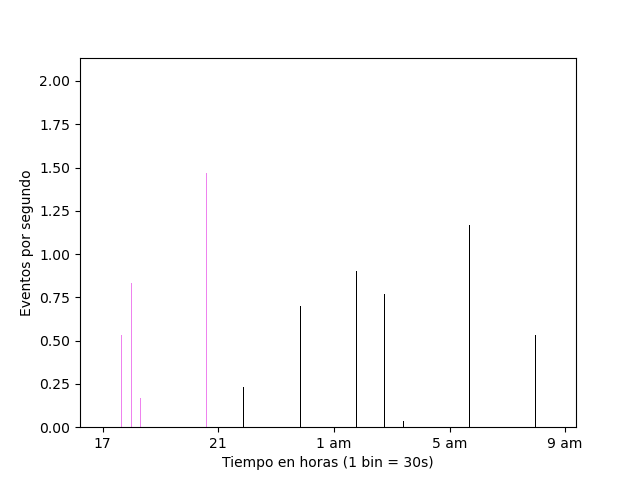

In [118]:
%matplotlib widget
ax1, fig = plt.subplots()
plt.bar(
    x=range(len(histograma)),
    height=[x/30 for x in histograma['Eventos']],
    color=histograma['color']
)
fig.set_ylabel('Eventos por segundo')
fig.set_xlabel('Tiempo en horas (1 bin = 30s)')
fig.set_xticklabels(xtickslab)
fig.set_xticks(xticks)
plt.show()     
ax1.savefig(r'C:/Users/Compras/Documents/resultados_petersii/hist_eventos_GP_P6.svg', format='svg')

In [124]:
folder = r"C:\Users\Compras\Documents\resultados_petersii"
os.chdir(folder)
histograms = glob.glob("*.csv")
histograms

['histograma_eventos_GP_p1.csv',
 'histograma_eventos_GP_p2.csv',
 'histograma_eventos_GP_p3.csv',
 'histograma_eventos_GP_p4.csv',
 'histograma_eventos_GP_p5.csv',
 'histograma_eventos_GP_p6.csv']

In [136]:
h = pd.read_csv(histograms[0], header=0)
h.groupby('objeto').mean()['Eventos']['Basal']

C:\Users\Compras\AppData\Local\Temp\ipykernel_6756\2966779512.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  h.groupby('objeto').mean()['Eventos']['Basal']


1.501923076923077

In [141]:
medias_b = []
medias_o = []
std = []
for histogram in histograms:
    h = pd.read_csv(histogram)
    medias_b.append(h.groupby('objeto').mean()['Eventos']['Basal'])
    medias_o.append(h.groupby('objeto').mean()['Eventos']['Objeto'])

    std.append(h.groupby('objeto').std()['Eventos'])

C:\Users\Compras\AppData\Local\Temp\ipykernel_6756\1889160668.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medias_b.append(h.groupby('objeto').mean()['Eventos']['Basal'])
C:\Users\Compras\AppData\Local\Temp\ipykernel_6756\1889160668.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medias_o.append(h.groupby('objeto').mean()['Eventos']['Objeto'])
C:\Users\Compras\AppData\Local\Temp\ipykernel_6756\1889160668.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only c

In [146]:
medias_histogramas = pd.DataFrame(zip(medias_o, medias_b), columns=['Objeto', 'Basal'])
#medias_histogramas = medias_histogramas.melt()
medias_histogramas

,Objeto,Basal
0,1.779915,1.501923
1,1.025641,1.198006
2,0.908120,1.314103
3,0.717949,1.143162
4,2.050549,1.594919
5,0.775641,0.559829


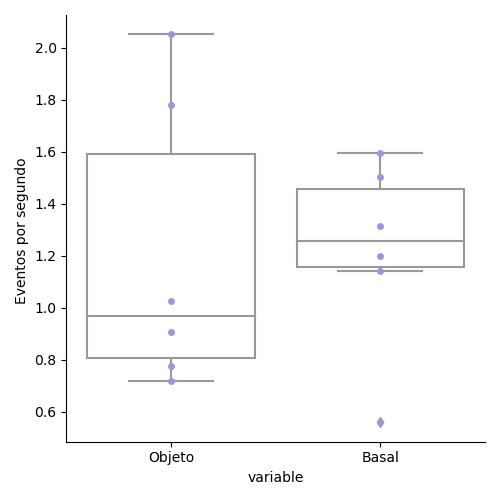

In [145]:
%matplotlib widget
import seaborn as sns
box = sns.catplot(data=medias_histogramas, 
            x = 'variable',
            y = 'value',
            kind='box',
            errorbar='sd',
            estimator='median',
            color='white')
points = sns.swarmplot(data=medias_histogramas, x='variable', y='value', size=5, color='#9B96E1')

box.set(ylabel='Eventos por segundo ')
plt.show()